<a href="https://colab.research.google.com/github/artisanvaultcode/predestrianRCNN/blob/main/Optimizer_Nadam_Detecting_Pedestrians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip -qo "/content/drive/MyDrive/PedestrianDataset.zip" -d "/content/drive/MyDrive/Pedestrians"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import cv2
import os
from xml.etree import ElementTree
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
keras = tf.keras

In [ ]:
class_names = ['person','person-like']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

n_classes = 2
size = (120,120)

In [ ]:
def load_data():
    datasets = ['/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Train/Train', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Test/Test', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = dataset +"/Annotations"
        directoryIMG = dataset +"/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:

            xmlf = os.path.join(directoryA,xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i +=1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')

        output.append((imags, labels))
    return output

In [ ]:
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [ ]:
train_images.shape

(944, 120, 120, 3)

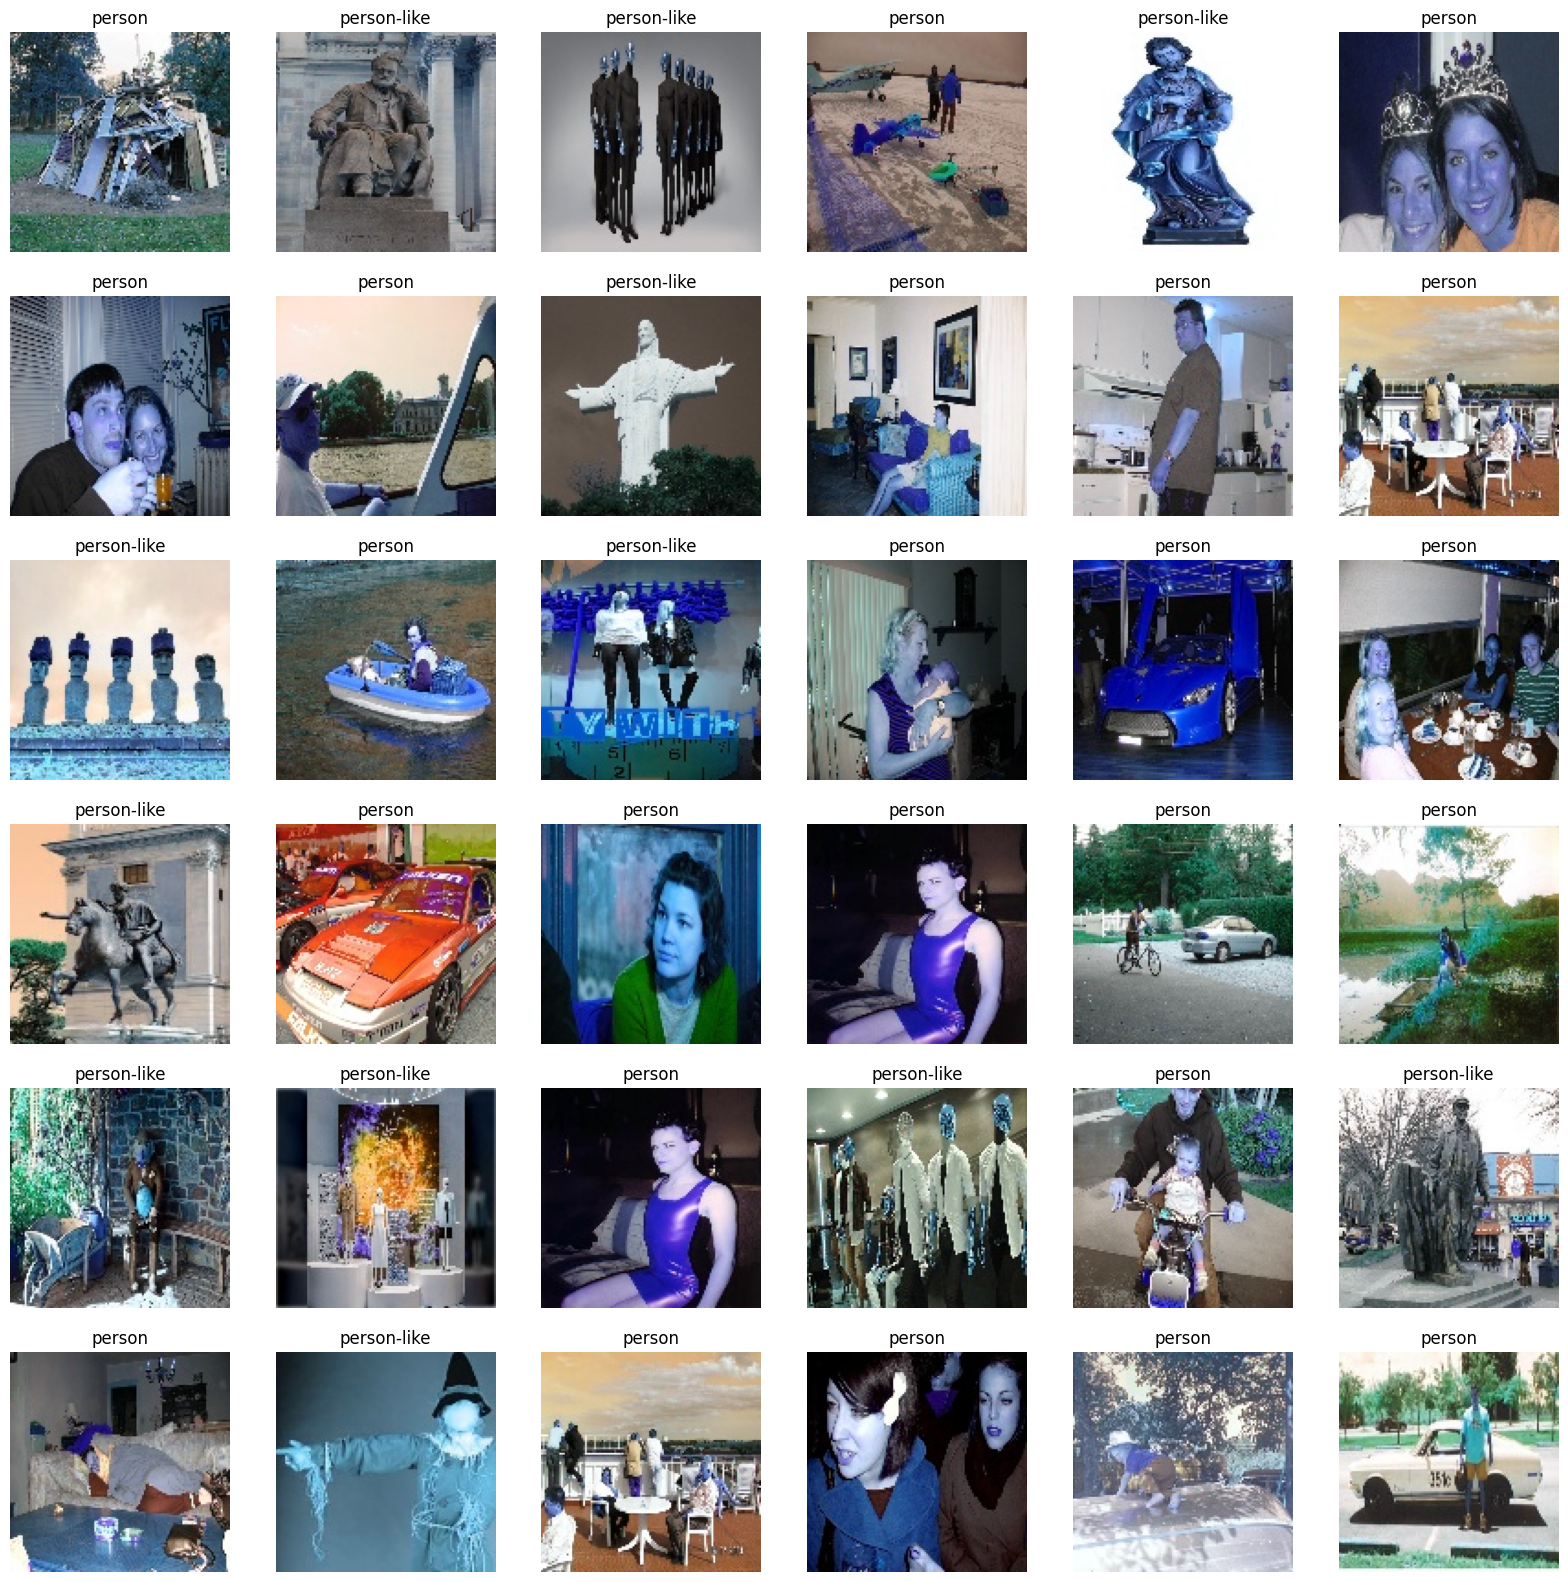

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')

In [ ]:
# Instanciate a Sequential model. This allows us to create a new model layer by layer in a sequential manner.
model = models.Sequential()

# Add a 2D Convolutional layer with 4 filters, each of 5x5 dimensions.
# It uses ReLU (Rectified Linear Unit) activation function.
# This is used to scan the input image with (5x5) filters and 'relu' is used as an activation function to introduce non-linearity into the model.
# This is the first layer in the model, hence input_shape is provided which matches with the shape of each image in dataset.
model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=(120, 120, 3)))

# Add a MaxPooling layer of pool size (2, 2). This is used to reduce the spatial dimensions (height & width) of input by taking maximum value within the window of (2, 2) at a time.
model.add(layers.MaxPooling2D((2, 2)))

# Add a 2D Convolutional layer with 12 filters of 2x2 size followed by a 'relu' activation function.
# This layer learns from the features extracted by previous convolutions, giving the model a deeper understanding of the input image.
model.add(layers.Conv2D(12, (2, 2), activation='relu'))

# Add another MaxPooling layer of pool size (2, 2).
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer is added to convert 2D or multidimensional data into a flat vector to be used as input to Dense layers.
model.add(layers.Flatten())

# A Dense layer with 16 units & 'relu' activation function which fully connects the input with 16 neurons.
model.add(layers.Dense(16, activation='relu'))

# Final Dense layer with 2 units. This is the output layer of the model. If this is used for binary classification you may want to add activation='softmax' for a probability distribution.
model.add(layers.Dense(2))

# Display a summary of the model, including layers and number of parameters.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 116, 116, 4)       304       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 58, 58, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 12)        204       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

1. from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
This line is importing the required callback classes from Keras.
2. es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
EarlyStopping is a Keras callback to stop training when a monitored metric has stopped improving. Here, it is set to monitor the model's accuracy and will stop the training if accuracy is not improving for 2 (patience=2) consecutive epochs (an epoch is one full loop over the entire training dataset). The mode is set to 'max' which means training will stop when accuracy is no longer maximising.
3. filepath = "modelPedestrianDetection.h5"
This line sets the filepath where the model checkpoint will be saved.
4. ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
ModelCheckpoint is a Keras callback to save the Keras model during training. The model will only be saved at the filepath when the accuracy improves (save_best_only=True). If the accuracy doesn't improve, the model won't be saved. This ensures that we only save the best model.
5. rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)
ReduceLROnPlateau is a Keras callback to reduce the learning rate when a metric has stopped improving which can help the model converge. Here, it is set to monitor the model's accuracy and will reduce the learning rate if accuracy is not improving for 2 (patience=2) consecutive epochs. verbose=1 means it will print an update message when the learning rate is reduced.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
filepath = "modelPedestrianDetection.h5"
ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)

Nadam, short for Nesterov-accelerated Adaptive Moment Estimation, is an optimizer that combines techniques from both Adam (Adaptive Moment Estimation) and Nesterov accelerated gradient.

In the context of pedestrian detection, if you're dealing with a high-dimensional space (like images), a complex model architecture, or a large and noisy dataset, an adaptive optimizer such as Adam or Nadam might be more suitable. These optimizers not only consider momentum but also adjust the learning rate on a per-parameter basis, which can be beneficial for tasks like pedestrian detection.

In [ ]:
from tensorflow.keras.optimizers import Nadam
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=nadam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

1. EarlyStopping: This callback will stop the training process when a monitored quantity has stopped improving. In this case:
  * monitor='accuracy': The quantity to be monitored is the "accuracy" on the training set.
  * mode='max': Training will stop when the quantity monitored has stopped increasing.
  * verbose=1: This will print to the console every time the EarlyStopping condition is met.
  * patience=2: Number of epochs with no improvement after which training will be stopped. In this case, training will stop if there is no improvement in accuracy for 2 consecutive epochs.
2. ModelCheckpoint: This callback saves the model after every epoch.
  * filepath: This is the file path where the model should be saved, in this case "modelPedestrianDetection.h5".
  * monitor='accuracy': The model saving criterion is the "accuracy" metric.
  * verbose=1: This flag will print to console every time a new model checkpoint is saved.
  * save_best_only=True: If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten.
  * mode='max': In 'max' mode, the model check pointing only happens when the monitored quantity ("accuracy") has improved.
3. ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving.
  * monitor='accuracy': The quantity to be monitored is the "accuracy".
  * patience=2: The number of epochs with no improvement after which learning rate will be reduced.
  * verbose=1: This flag allows printing to console each time the learning rate is reduced.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
filepath = "modelPedestrianDetection.h5"
ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)

1. train_images, train_labels: This is your training data. train_images are the inputs to your model and train_labels are the corresponding outputs.
2. epochs=60: This sets the number of epochs, which is the number of complete passes through the training dataset. In this case, the entire dataset will be passed forward and backward through the neural network 60 times.
3. validation_data=(test_images, test_labels): The validation_data parameter is used to evaluate the loss function and any model metrics at the end of each epoch on the provided dataset. The test_images and test_labels form the validation data in this case.
4. history = model.fit(...): model.fit() trains the model for a fixed number of epochs and returns a History object. This History object holds a record of the loss values and metric values during training.

In [ ]:
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
30/30 [==============================] - 12s 270ms/step - loss: 0.0600 - accuracy: 0.9862 - val_loss: 1.5414 - val_accuracy: 0.6851
Epoch 2/10
30/30 [==============================] - 10s 348ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.6814 - val_accuracy: 0.6766
Epoch 3/10
30/30 [==============================] - 7s 245ms/step - loss: 0.0028 - accuracy: 0.9979 - val_loss: 1.7443 - val_accuracy: 0.6851
Epoch 4/10
30/30 [==============================] - 10s 327ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 1.7954 - val_accuracy: 0.6809
Epoch 5/10
30/30 [==============================] - 7s 246ms/step - loss: 0.0024 - accuracy: 0.9979 - val_loss: 1.7848 - val_accuracy: 0.6851
Epoch 6/10
30/30 [==============================] - 10s 330ms/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 1.8021 - val_accuracy: 0.6809
Epoch 7/10
30/30 [==============================] - 11s 363ms/step - loss: 0.0022 - accuracy: 0.9989 - val_loss: 1.8381 - val_accuracy: 0.6894
E

In [ ]:
# Save model for deployment
import joblib
joblib.dump(history, '/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionNAdam1.pkl')

['/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionNAdam1.pkl']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)

In [ ]:
import numpy as np

X_train_vec = np.array([np.reshape(img, (-1,)) for img in train_images])

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

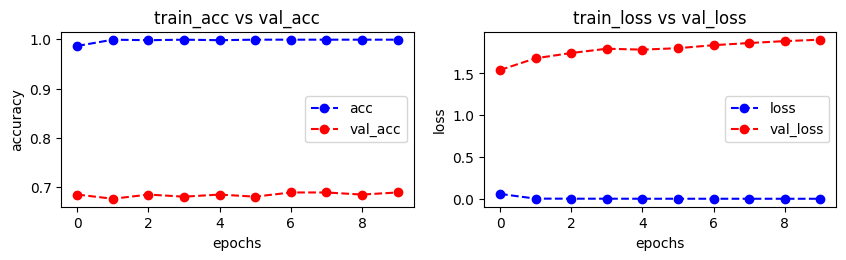

In [ ]:
plot_accuracy_loss(history)

In [ ]:
preds = model.predict(val_images)

5/5 [==============================] - 1s 166ms/step


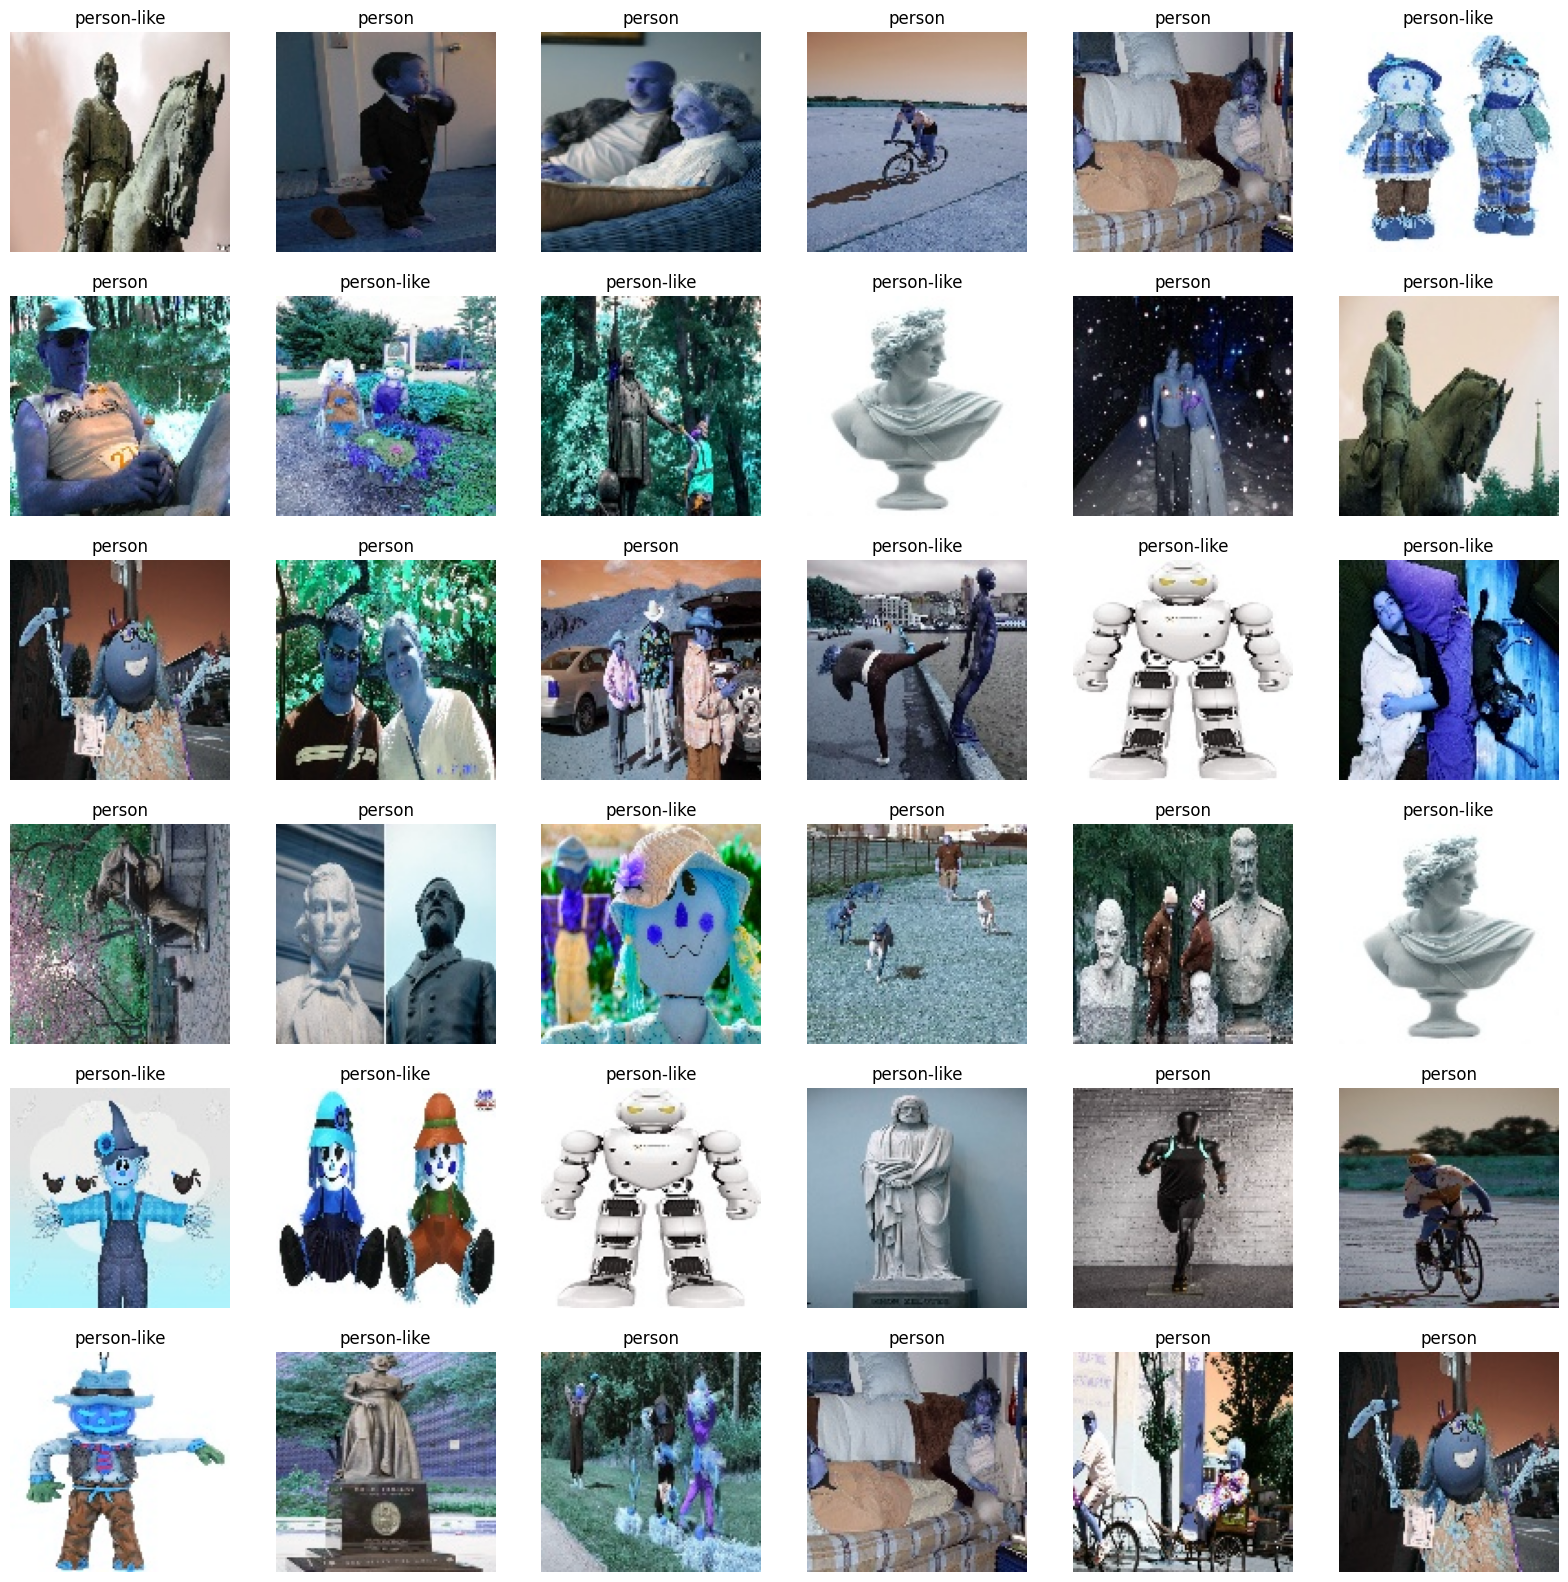

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites.
    plt.title((class_names[x]))

In [ ]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_labels,result).ravel()

In [ ]:
(tn, fp, fn, tp)

(64, 21, 24, 51)

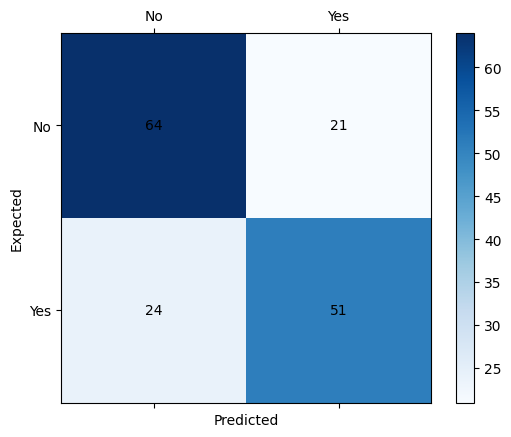

In [ ]:
conf_mat = confusion_matrix(val_labels,result)

fig, ax = plt.subplots()
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Draw the grid lines for the matrix
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    *model.evaluate(test_images, test_labels, verbose=2))
)

8/8 - 2s - loss: 1.9038 - accuracy: 0.6894 - 2s/epoch - 290ms/step
Final loss: 1.9038, final accuracy: 0.6894
